**логистическая регрессия** 

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

from sklearn.datasets import make_moons
X,target = make_moons(n_samples=n_samples, noise=.09)

y = target[:,np.newaxis]

X.shape, y.shape

((500, 2), (500, 1))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250, 1), (250, 2), (250, 1))

In [7]:
del X
del y

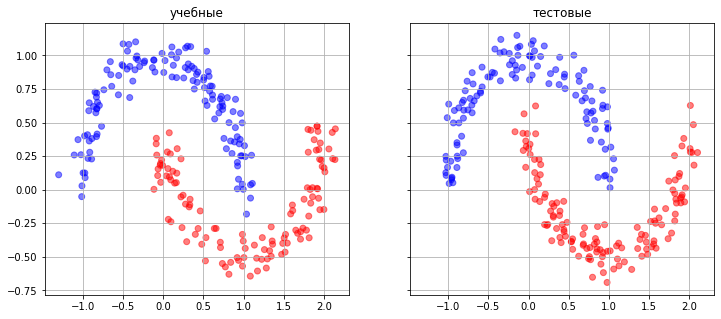

In [8]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly_degree = 3 # степень полинома

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures(poly_degree).fit(X_train)
Xp = poly.transform(X_train)
Xp.shape

(250, 10)

## модель

$$f(u) = \frac{1}{1+\exp(-u)}$$


In [10]:
def sigmoid(u): return 1./(1. + np.exp(-u))

act = sigmoid

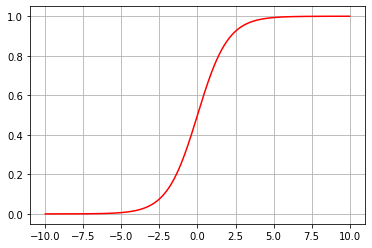

In [11]:
u=np.linspace(-10,10,500)
plt.plot( u,act(u),'-r' )
plt.grid()

$$\frac{\partial f}{\partial u} = \frac{\exp(-u)}{\left(1+\exp(-u)\right)^2} $$

In [12]:
def diff_sigmoid(u): # производная активации
    return ( np.square(sigmoid(u))*np.exp(-u) )[:,np.newaxis]

diff_act = diff_sigmoid

$$a(x,w) = f\left(\sum\limits_{i=1} x_i \cdot w_i + w_0\right)$$

In [13]:
def model(x,w): # модель логрегересии
    return act(x.dot(w))[:,np.newaxis]

In [14]:
def model_partial(x,w): # частные производные модели по её параметрам
    return diff_act( x.dot(w) )*x

## обучаем модель

фeyrция потери - кросс-энтропия
$$L = BCE(y,o) = -y\cdot log2(o) - (1-y) \cdot log2(1-o)  $$

In [15]:
def bce(y,o): # кросс-энтропия
    with np.errstate(divide='ignore',invalid='ignore'):
        # доопределяем нулями логарифм для аргументов меньше или равно 0
        l0 = np.where( o<1., (1-y)*np.log2(1.-o), 0. )
        l1 = np.where( o>0., y*np.log2(o),        0. ) 
    return -(l1+l0).sum()/len(y)

loss = bce

$$ \frac{\partial L}{\partial w} = -\frac{o-y }{o (o-1)}\cdot \frac{\partial o}{\partial w}$$ 

In [16]:
def bce_partial(x,w,y): # градиент функции потери
    o = model(x,w)
    p = model_partial(x,w)
    with np.errstate(divide='ignore',invalid='ignore'):
        d = o*(o-1)
        d = np.where(d!=0.,(1./d), .0 )
    g = -p.T.dot((o-y)/d).flatten()
    g /= np.abs(g).max()
    return g

gradient = bce_partial

$$L = CCE = -y\cdot \log\left( \frac{1}{1 + \exp(-x\cdot w)} \right)$$

---

In [17]:
def fit_epoch(x,y,w,lr): # шаг обучения модели
    g = gradient(x,w,y) # градиент CCE, изменение весов
    return w - lr*g # корректируем параметры

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
%%time

# метод градиентного спуска

lr = 1e-01 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 200 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = Xp.shape[1] # размер вектора признаков

# инициализация параметров модели
w = rng.normal(size=(n_param))
#w = np.array( [0] + [1]*(n_param-1) )

# начальное значение ф-ции потери
loss_history = [ loss(y_train,model(Xp,w)) ]
acc_history = [ accuracy_score( y_train , (model(Xp,w)>.5).astype(int) ) ]

for i in range(n_epoch): # цикл обучения
    w = fit_epoch(Xp,y_train,w,lr) # корректируем веса модели
    loss_history.append( loss(y_train,model(Xp,w)) ) # считаем значение ф-ции потери
    acc_history.append( accuracy_score( y_train , (model(Xp,w)>.5).astype(int) ) )
    
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

step 48/200: loss 0.277, acc threshold 0.980 reached

CPU times: user 43.5 ms, sys: 0 ns, total: 43.5 ms
Wall time: 42.7 ms


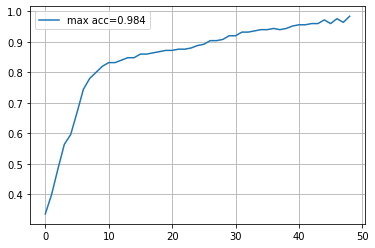

In [20]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)))
plt.grid()
plt.legend()

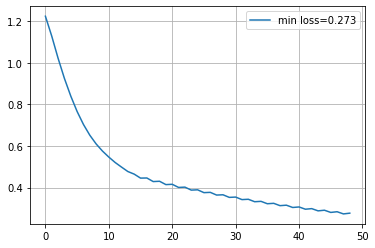

In [21]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [22]:
s = model(poly.transform(X_test),w)

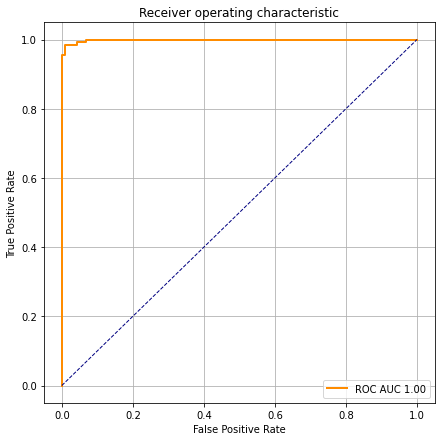

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test, s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.4426509710539697

In [25]:
p = (s>optimal_threshold).astype(int)
y = (y_test>0).astype(int)

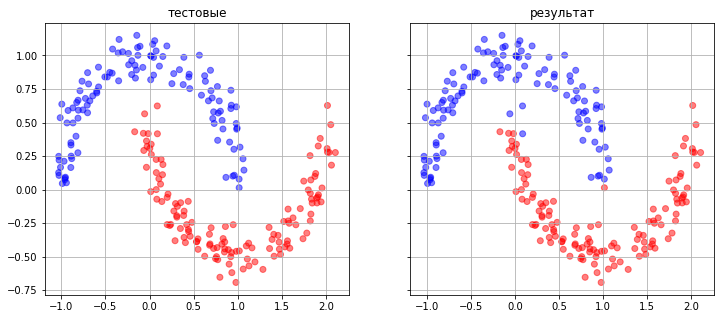

In [26]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       117
           1       0.99      0.98      0.98       133

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



## карта скоров

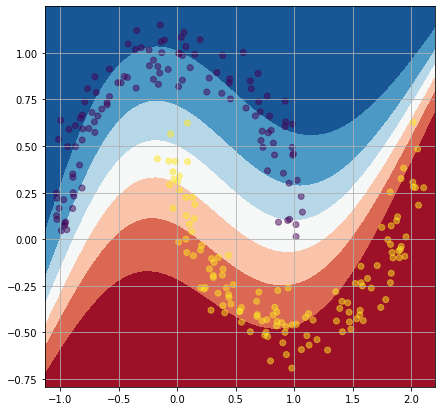

In [28]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 

s = model(poly.transform(xy),w)

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5 )
plt.grid()

----

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [29]:
# def msqe(y,o): # средняя квадратичная ошибка
#     d = o-y 
#     return d.T.dot(d).flatten()[0]/len(y)

# loss = msqe

частные производные функции потери по параметрам модели (градиент)

$$ \frac{\partial L }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

In [30]:
# def msqe_partial(x,w,y): # градиент функции потери,
#     g = model_partial(x,w).T.dot(model(x,w)-y) # градиент msqe
#     g /= np.abs(g).max() # нормируем градиент
#     return g.flatten()

# gradient = msqe_partial